In [1]:
# import warnings
warnings.filterwarnings("ignore")

In [2]:
# Importing packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
%matplotlib inline
plt.style.use('bmh')

In [68]:
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
from pandas.tseries.offsets import DateOffset
from statsmodels.tsa.stattools import adfuller
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

#### Reading Data

In [56]:
df = pd.read_csv("../data/gun_violence_cleaned_data_2013_2018.csv")

Monthly modifications are being done to the data.

In [58]:
df['date'] = pd.to_datetime(df['date'])
df['monthyear'] = df['date'].dt.to_period('M')

monthly_incidents = df.groupby('monthyear').size()
monthly_incidents.index = monthly_incidents.index.to_timestamp()

In [16]:
indices = []
for i in range(df.shape[0]):
    if 'mass' in df['incident_characteristics'].iloc[i]:
        indices.append(i)
df_mass = df.iloc[indices]

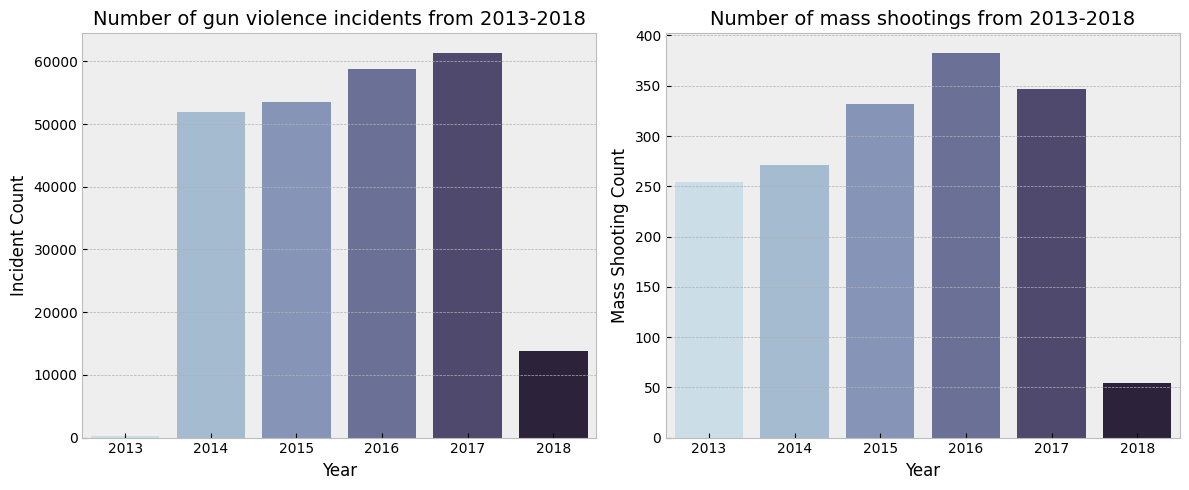

In [26]:
year_palette = sns.color_palette("ch:s=.25,rot=-.25", len(df['year'].unique()))
plt.figure(figsize=(12, 5))

plt.subplot(121)
sns.countplot(x='year', data=df, order=sorted(df['year'].unique()), palette=year_palette)
plt.title('Number of gun violence incidents from 2013-2018', fontsize=14)
plt.xlabel('Year')
plt.ylabel('Incident Count')

plt.subplot(122)
sns.countplot(x='year', data=df_mass, order=sorted(df_mass['year'].unique()), palette=year_palette)
plt.title('Number of mass shootings from 2013-2018', fontsize=14)
plt.xlabel('Year')
plt.ylabel('Mass Shooting Count')

plt.tight_layout()
plt.show()

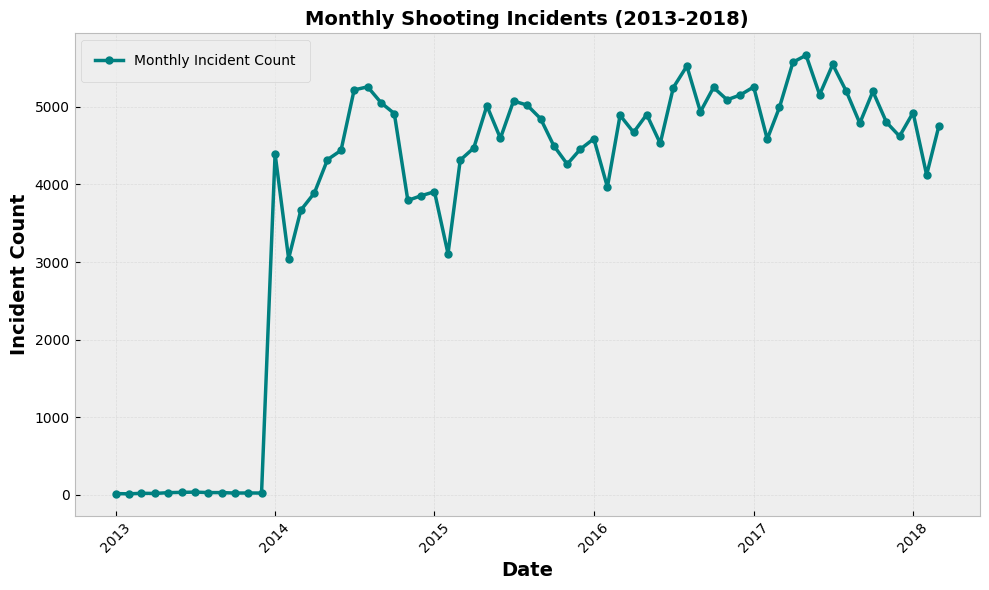

In [30]:
plt.figure(figsize=(10, 6))

plt.plot(monthly_incidents, color='teal', linewidth=2.5, marker='o', markersize=5, label="Monthly Incident Count")
plt.title("Monthly Shooting Incidents (2013-2018)", fontsize=14, fontweight='bold')
plt.xlabel("Date", fontsize=14, fontweight='bold')
plt.ylabel("Incident Count", fontsize=14, fontweight='bold')

plt.xticks(fontsize=10, rotation=45)
plt.yticks(fontsize=10)

plt.grid(alpha=0.3)
plt.legend(loc="upper left", fontsize=10, frameon=True, borderpad=1)
plt.tight_layout()
plt.show()

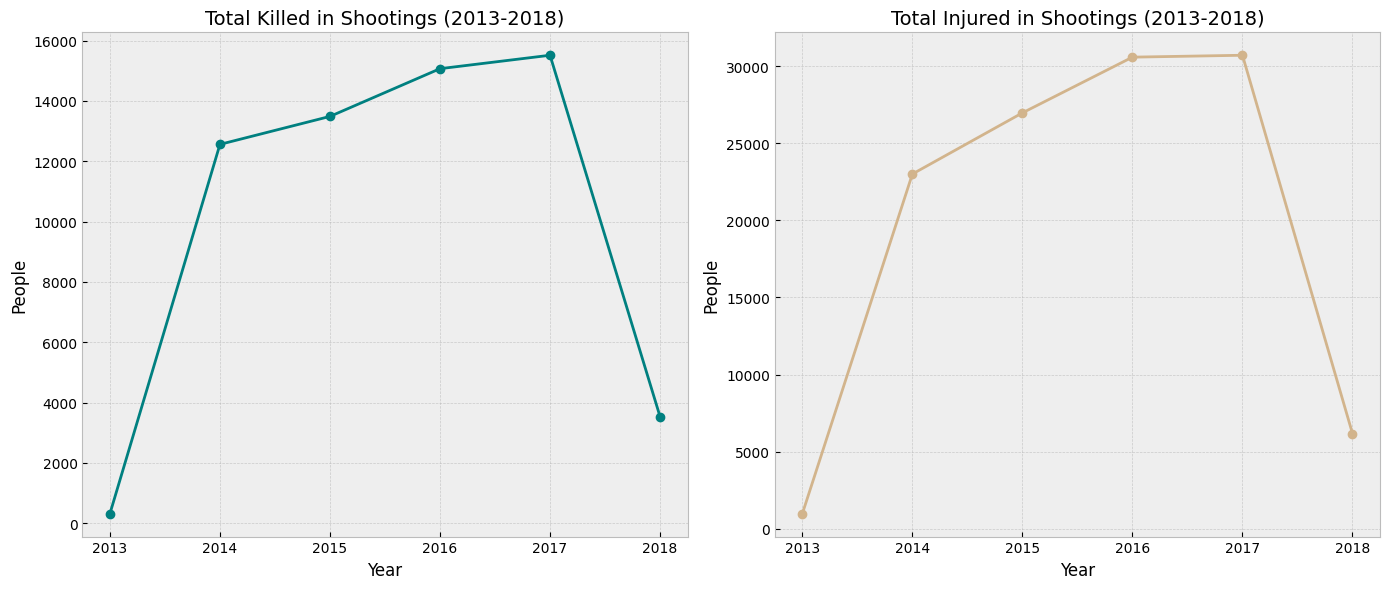

In [42]:
plt.figure(figsize=(14, 6))

plt.subplot(121)
plt.title("Total Killed in Shootings (2013-2018)", fontsize=14)
plt.ylabel("People")
plt.xlabel("Year")
plt.plot(df.groupby('year')['n_killed'].sum(), marker='o', color='teal', linestyle='-', linewidth=2)
plt.grid(True, linestyle='--', alpha=0.6)

plt.subplot(122)
plt.title("Total Injured in Shootings (2013-2018)", fontsize=14)
plt.ylabel("People")
plt.xlabel("Year")
plt.plot(df.groupby('year')['n_injured'].sum(), marker='o', color='tan', linestyle='-', linewidth=2)
plt.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

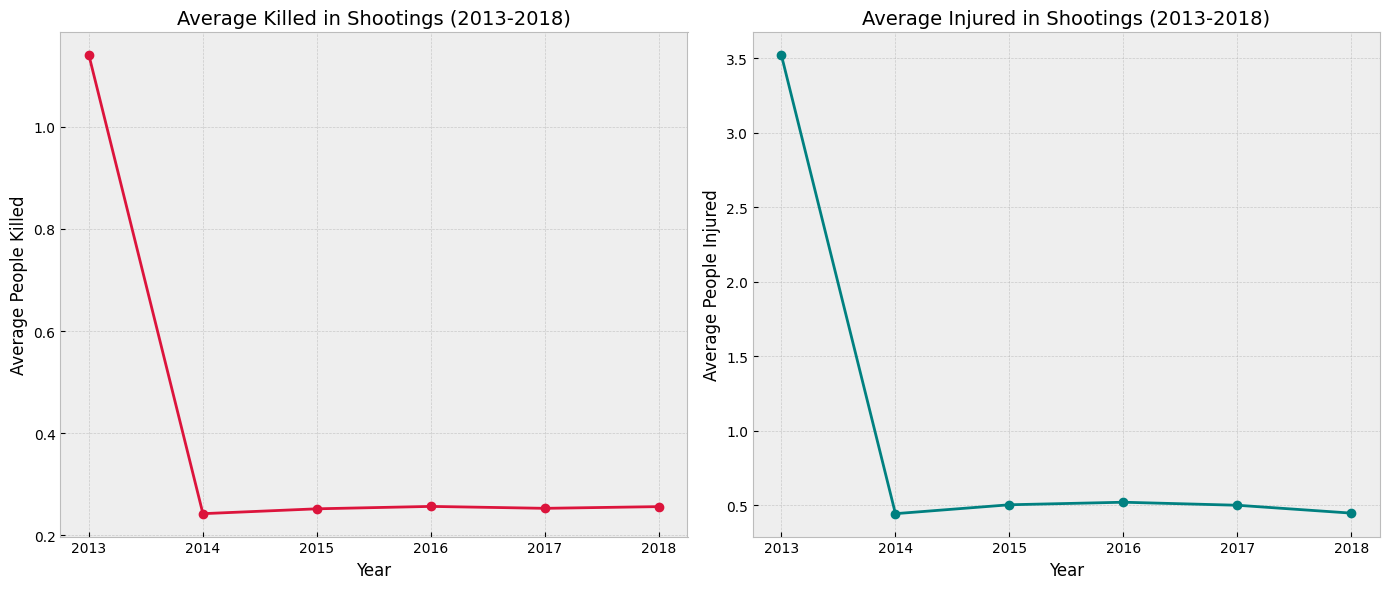

In [44]:
plt.figure(figsize=(14, 6))
plt.subplot(121)
plt.title("Average Killed in Shootings (2013-2018)", fontsize=14)
plt.ylabel("Average People Killed")
plt.xlabel("Year")
plt.plot(df.groupby('year')['n_killed'].mean(), marker='o', color='crimson', linestyle='-', linewidth=2)
plt.grid(True, linestyle='--', alpha=0.6)

plt.subplot(122)
plt.title("Average Injured in Shootings (2013-2018)", fontsize=14)
plt.ylabel("Average People Injured")
plt.xlabel("Year")
plt.plot(df.groupby('year')['n_injured'].mean(), marker='o', color='teal', linestyle='-', linewidth=2)
plt.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

In [76]:
df['monthyear'] = df['monthyear'].dt.to_timestamp()

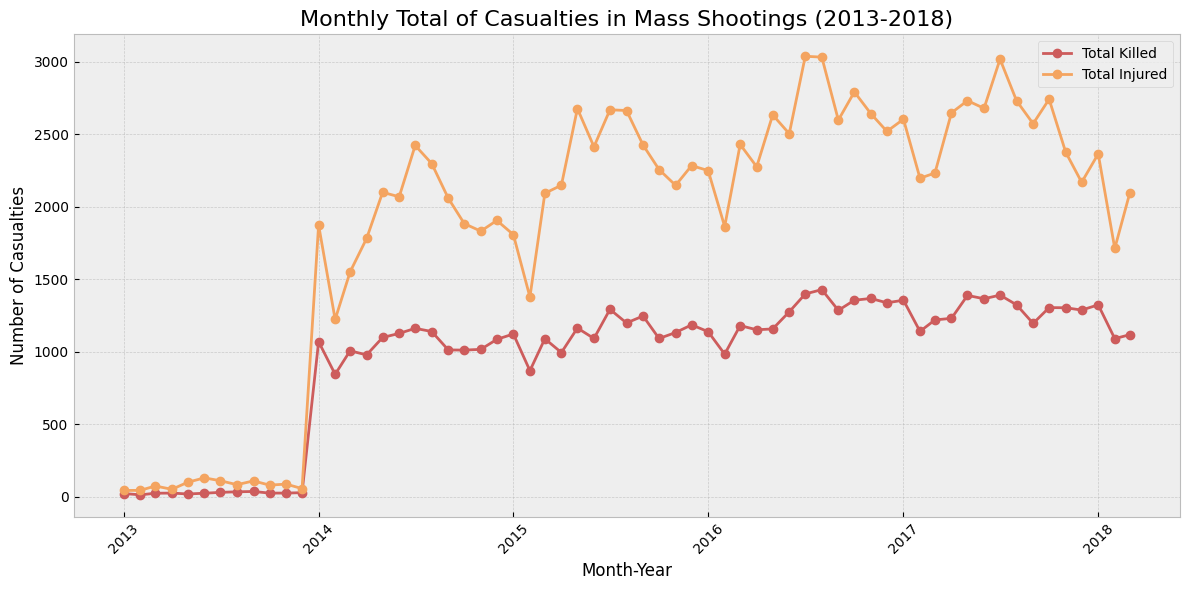

In [78]:
plt.figure(figsize=(12, 6))
plt.plot(df.groupby('monthyear')['n_killed'].sum(), label='Total Killed', color='indianred', marker='o', linestyle='-', linewidth=2)
plt.plot(df.groupby('monthyear')['n_injured'].sum(), label='Total Injured', color='sandybrown', marker='o', linestyle='-', linewidth=2)

plt.title("Monthly Total of Casualties in Mass Shootings (2013-2018)", fontsize=16)
plt.xlabel("Month-Year", fontsize=12)
plt.ylabel("Number of Casualties", fontsize=12)

plt.legend(loc='best', fontsize=10)
plt.grid(True, linestyle='--', alpha=0.6)

plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

### Augmented Dickey-Fuller (ADF) test

It helps determine if a time series is stationary or non-stationary.

Why the ADF Test is Important:
- The ADF test checks if a time series is stationary, a crucial assumption for many time series models, such as ARIMA.
- Stationary data has constant mean, variance, and autocorrelation over time, making it predictable. Non-stationary data may need transformations, like differencing, to meet model requirements.

In [80]:
def perform_adf_test(time_series):
    """
    Perform the Augmented Dickey-Fuller test to assess stationarity of the time series.
    
    Parameters:
    time_series (pd.Series): The time series data to test.
    
    Returns:
    None: Prints the ADF test summary and interpretation.
    """
    result = adfuller(time_series)

    print('Augmented Dickey-Fuller Test Results:')
    labels = ['ADF Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used']
    for label, value in zip(labels, result[:4]):
        print(f"{label}: {value}")

    print("\nCritical Values:")
    for key, value in result[4].items():
        print(f"    {key}: {value}")

    if result[1] <= 0.05:
        print("\nConclusion: Strong evidence against the null hypothesis (H0), suggesting the data is stationary.")
    else:
        print("\nConclusion: Weak evidence against the null hypothesis (H0), suggesting the data is non-stationary.")

In [82]:
ts = df.groupby('monthyear')['incident_id'].count().reset_index()
ts.columns = ['month','total']
ts['month'] = pd.to_datetime(ts['month'])
ts.set_index('month',inplace=True)

### Seasonal Decomposition Plots

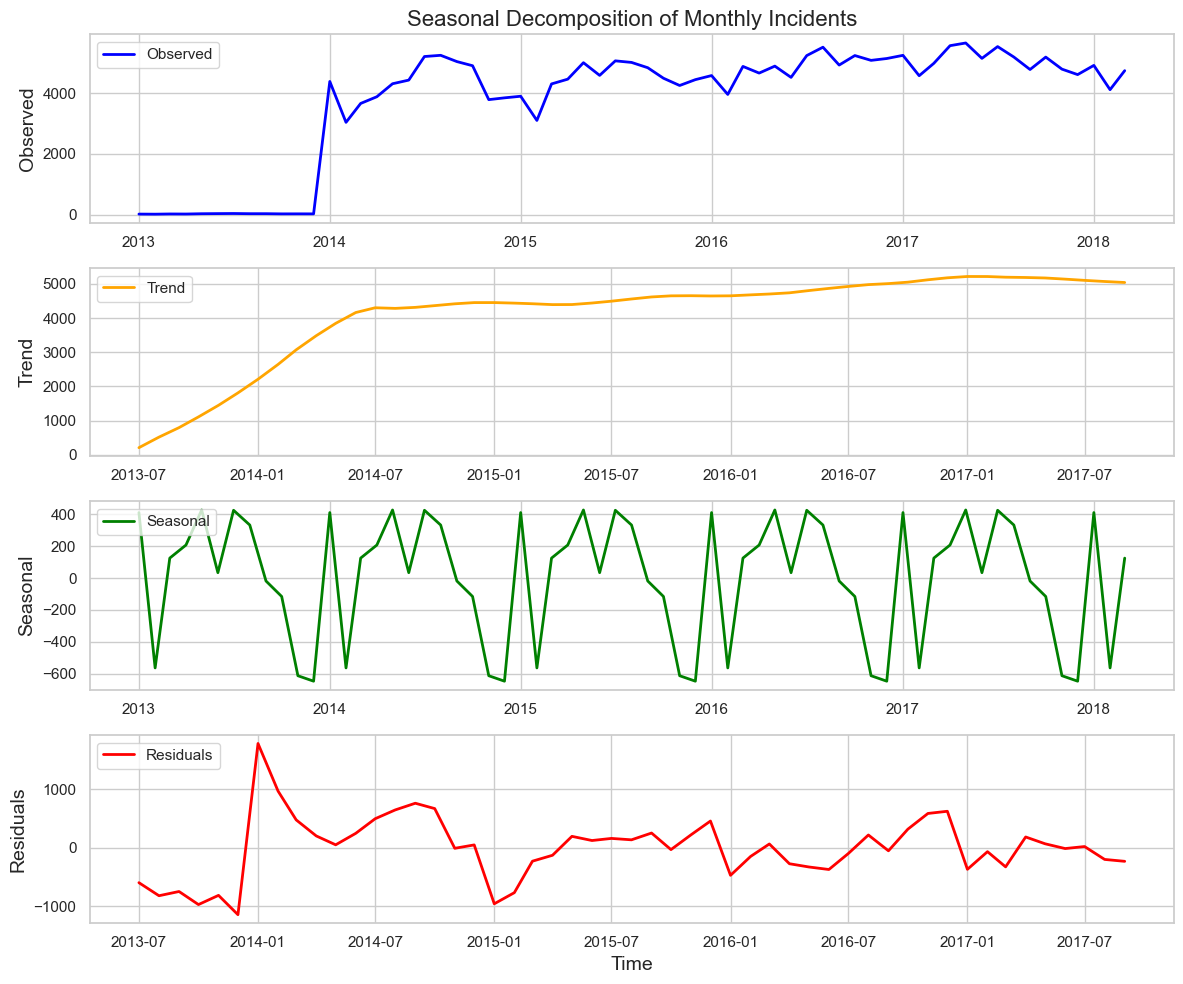

In [90]:
decomposition = seasonal_decompose(ts["total"], model='additive', period=12)

sns.set(style='whitegrid')
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(12, 10))

axes[0].plot(decomposition.observed, color='blue', label='Observed', linewidth=2)
axes[0].set_title('Seasonal Decomposition of Monthly Incidents', fontsize=16)
axes[0].set_ylabel('Observed', fontsize=14)
axes[0].legend(loc='upper left')

axes[1].plot(decomposition.trend, color='orange', label='Trend', linewidth=2)
axes[1].set_ylabel('Trend', fontsize=14)
axes[1].legend(loc='upper left')

axes[2].plot(decomposition.seasonal, color='green', label='Seasonal', linewidth=2)
axes[2].set_ylabel('Seasonal', fontsize=14)
axes[2].legend(loc='upper left')

axes[3].plot(decomposition.resid, color='red', label='Residuals', linewidth=2)
axes[3].set_ylabel('Residuals', fontsize=14)
axes[3].set_xlabel('Time', fontsize=14)
axes[3].legend(loc='upper left')

for ax in axes:
    ax.grid(True)

plt.tight_layout()
plt.show()

In [92]:
perform_adf_test(ts["total"])

Augmented Dickey-Fuller Test Results:
ADF Test Statistic: -2.05929744286299
p-value: 0.2611929643578449
#Lags Used: 1
Number of Observations Used: 61

Critical Values:
    1%: -3.542412746661615
    5%: -2.910236235808284
    10%: -2.5927445767266866

Conclusion: Weak evidence against the null hypothesis (H0), suggesting the data is non-stationary.


The results suggest that the time series is non-stationary. This means:

- The data likely has trends, seasonality, or other patterns that prevent it from being constant over time.
- Non-stationary data can lead to inaccurate or unstable forecasts if used directly in models like ARIMA.

In [96]:
ts['first_difference'] = ts['total'] - ts['total'].shift(1)
perform_adf_test(ts['first_difference'].dropna())

Augmented Dickey-Fuller Test Results:
ADF Test Statistic: -10.757236994842238
p-value: 2.5744632543964214e-19
#Lags Used: 0
Number of Observations Used: 61

Critical Values:
    1%: -3.542412746661615
    5%: -2.910236235808284
    10%: -2.5927445767266866

Conclusion: Strong evidence against the null hypothesis (H0), suggesting the data is stationary.


### SARIMAX

In [100]:
model = sm.tsa.statespace.SARIMAX(ts['total'],order=(0,1,0), seasonal_order=(1,1,1,12))
model_fit = model.fit()
print(model_fit.summary())

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.12440D+00    |proj g|=  5.08250D-01

At iterate    5    f=  6.63822D+00    |proj g|=  3.04678D-02

At iterate   10    f=  6.51414D+00    |proj g|=  3.88294D-03

At iterate   15    f=  6.23318D+00    |proj g|=  3.32075D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     18     21      1     0     0   3.723D-06   6.233D+00
  F =   6.2330245561187478     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
        

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.
